In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from RF.RF_Prediction_G12D import top_10_chembl_ids

filename = "../Raw Files/G12C_training.csv"
df = pd.read_csv(filename)
df = df.drop_duplicates(subset=['Smiles', 'IC50 (nM)'])


df = df.dropna()
print(len(df))

def pIC50(input_df):
    input_df = input_df.copy()
    input_df["IC50 (nM)"] = pd.to_numeric(input_df["IC50 (nM)"], errors='coerce')

    # Replace zeros with a small value (1e-12 nM = 1e-21 M)
    molar = np.where(input_df["IC50 (nM)"] == 0,
                     1e-12 * 1e-9,
                     input_df["IC50 (nM)"] * 1e-9)

    return -np.log10(molar)
# Filter and sample data before splitting
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


df = df.dropna(subset=['IC50 (nM)'])  # Remove rows with invalid IC50
print(len(df))



df = df[(df['FC'] == 0)] #& (df['IC50 (nM)'] <= 10)]
y = df['IC50 (nM)']


df['pIC50'] = pIC50(df)  # New column
df = df[df['pIC50'] <= 20]
print(len(df))

y = df['pIC50']  # <-- Now using correct column
X = df.drop(columns=["ChEMBL ID", "FC", 'IC50 (nM)', "Smiles", "pIC50"])  # Drop old IC50 and new pIC50


# --- Initialize Pipeline ---
pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(threshold=0.8*(1-0.8))),
    ('univariate_select', SelectKBest(score_func=f_regression, k=50)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(max_depth=20, min_samples_leaf=10, random_state=42))
])

# --- Load New Data ---
new_descriptors = pd.read_csv('../Raw Files/FDA_Hyb_Features.csv')
new_descriptors.dropna(inplace=True)
chembl_id_column = new_descriptors['ChEMBL ID']
smiles_column = new_descriptors['Smiles']
X_new = new_descriptors.drop(columns=['ChEMBL ID', 'Smiles'])

# --- Align New Data with Training Features ---
missing_cols = set(X.columns) - set(X_new.columns)
for col in missing_cols:
    X_new[col] = 0  # Add missing columns with 0
X_new = X_new[X.columns]  # Ensure column order matches

# --- Track Results ---
loop_results_df = pd.DataFrame(columns=['ChEMBL ID', 'Smiles', 'Predicted Value'])
predicted_values = {chembl_id: [] for chembl_id in chembl_id_column.unique()}
feature_importances = []
perm_importances = []
all_selected_features = []

# --- Main Loop ---
for i in range(50):  # 50 iterations
    pipe.fit(X, y)
    
    # Get selected features for this iteration
    vt_mask = pipe.named_steps['variance_threshold'].get_support()
    remaining_features = X.columns[vt_mask].tolist()
    skb_mask = pipe.named_steps['univariate_select'].get_support()
    selected_features = [remaining_features[i] for i in range(len(remaining_features)) if skb_mask[i]]
    all_selected_features.append(selected_features)
    
    # Predict
    loop_predicted_values = pipe.predict(X_new)
    
    # Store predictions
    loop_df = pd.DataFrame({
        'ChEMBL ID': chembl_id_column,
        'Smiles': smiles_column,
        'Predicted Value': loop_predicted_values
    }).sort_values('Predicted Value', ascending=False)
    
    loop_results_df = pd.concat([loop_results_df, loop_df.head(10)])
    
    # Store predicted values per ChEMBL ID
    for chembl_id, pred in zip(chembl_id_column, loop_predicted_values):
        predicted_values[chembl_id].append(pred)
    
    # Get feature importances (only for selected features)
    rf_model = pipe.named_steps['model']
    feature_importances.append(rf_model.feature_importances_)
    
    # Get permutation importance (on selected features)
    X_transformed = pipe[:-1].transform(X)  # Apply all steps except model
    result = permutation_importance(
        pipe.named_steps['model'], 
        X_transformed, 
        y, 
        n_repeats=10, 
        random_state=42
    )
    perm_importances.append(result.importances_mean)

# --- Post-Processing ---
# Average importances (only for selected features)
avg_feature_importance = np.mean(feature_importances, axis=0)
avg_perm_importance = np.mean(perm_importances, axis=0)

# Create importance DataFrames
feature_df = pd.DataFrame({
    'Feature': selected_features,  # Use the last iteration's selected features
    'Importance': avg_feature_importance
}).sort_values('Importance', ascending=False)

perm_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': avg_perm_importance
}).sort_values('Importance', ascending=False)

# --- Analyze Top Predictions ---
value_counts = loop_results_df['ChEMBL ID'].value_counts(normalize=True) * 10
top_10_chembl_ids0_chembl_ids = value_counts.head(10).index

454
454
452


/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_17789/1369136203.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loop_results_df = pd.concat([loop_results_df, loop_df.head(30)])


<Figure size 1200x800 with 0 Axes>

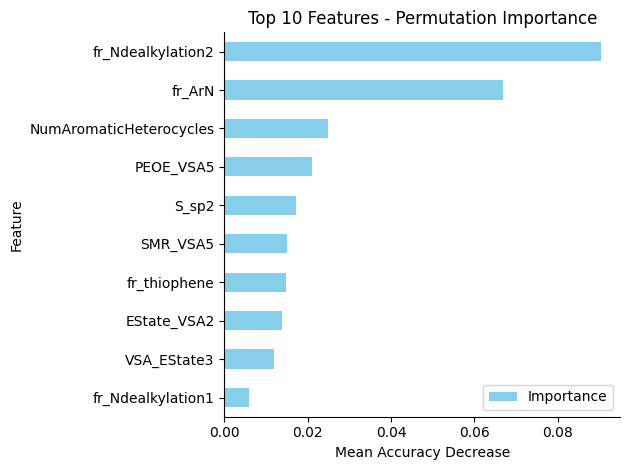

In [10]:
import matplotlib.pyplot as plt
# Plot Permutation Importance
plt.figure(figsize=(12, 8))
perm_df.head(10).sort_values('Importance', ascending=True).plot.barh(
    x='Feature', y='Importance', color='skyblue'
)
plt.title('Top 10 Features - Permutation Importance')
plt.xlabel('Mean Accuracy Decrease')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('permutation_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
mean_values = {chembl_id: np.mean(predicted_values[chembl_id]) for chembl_id in top_10_chembl_ids}
std_dev_values = {chembl_id: np.std(predicted_values[chembl_id]) for chembl_id in top_10_chembl_ids}

summary_df = pd.DataFrame({
    'ChEMBL ID': top_10_chembl_ids,
    'Frequency': [value_counts[chembl_id] for chembl_id in top_10_chembl_ids],
    'Avg Predicted Value': [mean_values[chembl_id] for chembl_id in top_10_chembl_ids]
})

summary_df.head(10)
summary_df.to_csv("RF_Molecules_G12C.csv", index=False)